# Inference: Logistic Growth with Combined Gaussian Error

This example shows you how to perform Bayesian inference on a time-series problem with a combined Gaussian error, using [Hamiltonian Monte Carlo](http://pints.readthedocs.io/en/latest/mcmc_samplers/hamiltonian_mcmc.html).

A combined Gaussian error is a Gaussian error whose standard deviation receives a constant contribution $\sigma _{\text{base}}$, and a contribution $\sigma _{\text{rel}}$ that scales with the model output. In other words, for a model $f(t; \theta)$ its combined Gaussian error is

\begin{equation*}
    \varepsilon = \left(\sigma _{\text{base}} + \sigma _{\text{rel}} f(t; \theta)^{\eta}\right) \varepsilon _n,
\end{equation*}

where $\eta $ is some constant that controls the relative scaling behaviour of the error. $\varepsilon _n$ is a standard Gaussian random variable, $\varepsilon _n\sim \mathcal{N}(0, 1)$.

As a toy time-series we consider a logistic Growth

\begin{equation*}
    f(t; \theta) = \frac{k}{1 + (k / f_0 - 1) e^{-r t}},
\end{equation*}

where the model parameters $\theta = (f_0, r, k)$ is the initial population size $f(t=0, \theta) = f_0$, the growth rate $r$ and the carrying capacity $k$. A logistic growth model with a combined Gaussian error

\begin{equation*}
    y(t; \theta, \sigma _{\text{base}}, \eta, \sigma _{\text{rel}}) = f(t; \theta)f(t, \theta) + \left(\sigma _{\text{base}} + \sigma _{\text{rel}} f(t; \theta)^{\eta}\right) \varepsilon _n,
\end{equation*}

has thus 6 model parameters which we may want to learn from data.

## Generating data

To illustrate how Bayesian inference may be used to learn the parameters of a logistic growth model with a combined Gaussian error, let us generate some data for a fixed set of model parameters

\begin{equation*}
    (f_0, r, k, \sigma _{\text{base}}, \eta, \sigma _{\text{rel}}) = (2, 0.015, 500, 10, 1.1, 0.05).
\end{equation*}

In [1]:
#
# Generate data for a logistic growth with a combined Gaussian error.
#

import numpy as np
import pints.toy


# Define model parameters
parameters = [2, 0.015, 500, 10, 1.1, 0.05]
f_0, r, k, sigma_base, eta, sigma_rel = parameters

# Instantiate logistic growth model with f(t=0) = f_0
model = pints.toy.LogisticModel(initial_population_size=f_0)

# Define measurement time points
times = np.linspace(start=0, stop=1000, num=100)

# Solve logistic growth model
model_output = model.simulate(parameters=[r, k], times=times)

# Add noise to the model output according to the combined Gaussian error model
# Draw a standard Gaussian random variable for each model output
gauss = np.random.normal(loc=0.0, scale=1.0, size=len(model_output))

# Scale standard Gaussian noise according to error model
error = (sigma_base + sigma_rel * model_output**eta) * gauss

# Add noise to model output
observations = model_output + error

# Save data as time-observation tuples
data = np.vstack([times, observations])

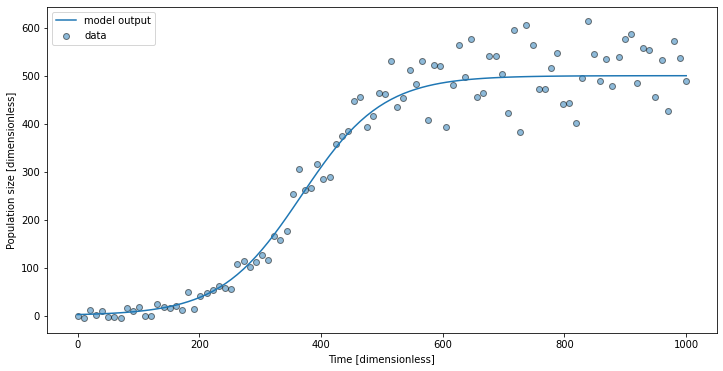

In [2]:
#
# Illustrate data.
#
# This cell needs the above defined data and model output:
# [data, model_output]
#

import matplotlib.pyplot as plt


# Create figure
plt.figure(figsize=(12, 6))

# Plot model output (no noise)
plt.plot(data[0, :], model_output, label='model output')

# Plot generated data
plt.scatter(data[0, :], data[1, :], label='data', edgecolors='black', alpha=0.5)

# Create X and Y axis title
plt.xlabel('Time [dimensionless]')
plt.ylabel('Population size [dimensionless]')

# Create legend
plt.legend()

# Show figure
plt.show()

## Inference of model parameters

We now try to recover the model parameters using 

1. [`pints.HaarioACMC`](https://pints.readthedocs.io/en/latest/mcmc_samplers/haario_ac_mcmc.html)
2. [`pints.HamiltonianMCMC`](https://pints.readthedocs.io/en/latest/mcmc_samplers/hamiltonian_mcmc.html).

In order to do that we need to construct a [`pints.LogPosterior`](https://pints.readthedocs.io/en/latest/log_pdfs.html#pints.LogPosterior) that incorporates the above simulated data, the logistic growth model and the error model. For a detailed introduction how to do this in [pints](https://pints.readthedocs.io/en/latest/), please have a look at the dedicated [notebooks](https://github.com/pints-team/pints/blob/master/examples/sampling/first-example.ipynb).

Let us simplify the inference by fixing the initial population size $f_0$ and the carrying capacity $k$ to the true values.

In [3]:
#
# Construct posterior.
#
# Step 1: Wrap logistic growth model in a pints.ForwardModel()
# Step 2: Create a pints.SingleOutputProblem(), combining the data and the wrapped logostic growth model.
# Step 3: Create a pints.CombinedGaussianLogLikelihood() from the pints.SingleOutputProblem()
# Step 4: Define pints.LogPrior() for the model parameters.
# Step 5: Combine priors and likelihood to create a pints.LogPosterior().
#
# This cell needs the above defined true parameters, and the generated data:
# [parameters, data]
#

import numpy as np
import pints
import pints.toy


# Get true initial population size and carrying capacity
f_0 = parameters[0]
k = parameters[2]

# Forget about f_0 and k (we won't infer those parameters)
true_parameters = np.hstack([parameters[1:2], parameters[3:]])

# Create a wrapper around the logistic model
class Model(pints.ForwardModel):
    def __init__(self, f_0, k):
        self._k = k
        self._model = pints.toy.LogisticModel(initial_population_size=f_0)
    def simulate(self, parameters, times):
        return self._model.simulate(parameters=[parameters[0], self._k], times=times)
    def simulateS1(self, parameters, times):
        # Compute model output and gradients w.r.t. r and k
        values, gradient = self._model.simulateS1(parameters=[parameters[0], self._k], times=times)

        # Get gradient w.r.t. r
        gradient = gradient[:, 0]

        return values, gradient
    def n_parameters(self):
        return 1

# Create an inverse problem which links the logistic growth model to the data
problem = pints.SingleOutputProblem(model=Model(f_0=f_0, k=k), times=data[0, :], values=data[1, :])

# Create the combined Gaussian error log-likelihood
log_likelihood = pints.CombinedGaussianLogLikelihood(problem)

# Create uniform priors for [r, sigma_base, eta, sigma_rel]
log_prior_r = pints.UniformLogPrior(
    [0.005],
    [0.02]
)
log_prior_sigma_base = pints.UniformLogPrior(
    [1],
    [20]
)
log_prior_eta = pints.UniformLogPrior(
    [0.5],
    [1.5]
)
log_prior_sigma_rel = pints.UniformLogPrior(
    [0.001],
    [1]
)
log_prior = pints.ComposedLogPrior(
    log_prior_r, log_prior_sigma_base, log_prior_eta, log_prior_sigma_rel)

# Create posterior
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

### 1. Infer parameters with Haario Adaptive Covariance MCMC

In [4]:
#
# Infer model parameters with Haario ACMC.
#
# This cell needs the above defined true model parameters and the log-posterior:
# [true_parameters, log_posterior]
#

# Choose starting points for mcmc chains
xs = [
    true_parameters * 1.01,
    true_parameters * 0.9,
    true_parameters * 1.15,
]

# Create MCMC routine
mcmc = pints.MCMCController(
    log_pdf=log_posterior, 
    chains=len(xs),  # number of chains
    x0=xs,   # starting points
    method=pints.HaarioACMC)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Run!
print('Running...')
hacmc_chains = mcmc.run()
print('Done!')

Running...
Using Haario adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0         0         0          0:00.0
100   303    0.0099    0.0495    0.0297     0:00.1
Initial phase completed.
200   603    0.0149    0.0249    0.0249     0:00.1
300   903    0.159     0.163     0.173      0:00.2
400   1203   0.18      0.175     0.19       0:00.3
500   1503   0.186     0.188     0.198      0:00.3
600   1803   0.178     0.196     0.205      0:00.4
700   2103   0.178     0.197     0.197      0:00.5
800   2403   0.177     0.19      0.197      0:00.6
900   2703   0.181     0.190899  0.193      0:00.6
1000  3003   0.184     0.193     0.192      0:00.7
1100  3303   0.185     0.181     0.197      0:00.8
1200  3603   0.184846  0.176     0.2        0:00.9
1300  3903

param       mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
----------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
r           0.01    0.00    0.01    0.01   0.01   0.02   0.02     1.00    1303.34  190.24
sigma_base  6.56    1.65    3.71    5.44   6.44   7.50   10.19    1.04    96.66    14.11
eta         0.82    0.12    0.64    0.73   0.81   0.91   1.08     1.08    46.75    6.82
sigma_rel   0.37    0.23    0.06    0.18   0.32   0.53   0.90     1.08    58.87    8.59


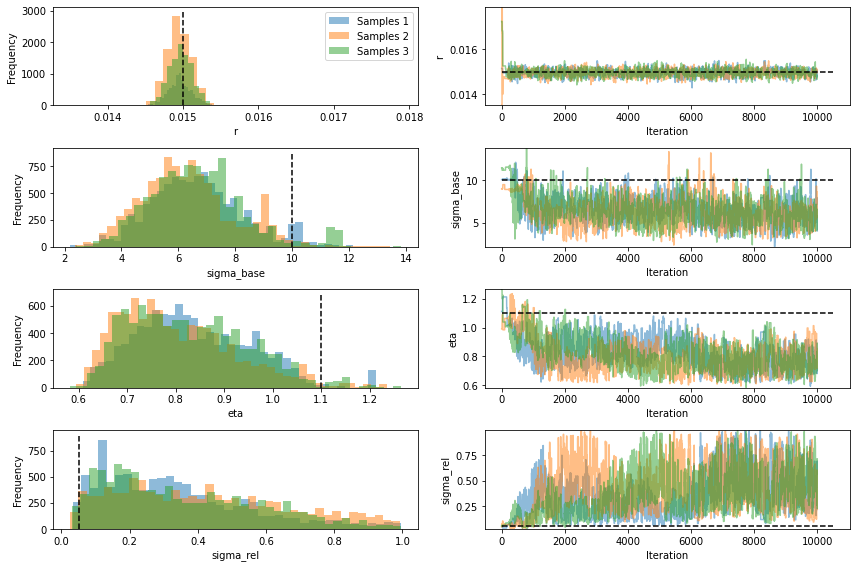

In [5]:
#
# Compute diagnostics and show diagnostic plots.
#
# This cell needs the HaarioACMC chains:
# [hacmc_chains]
#

import pints
import pints.plot


# Show diagnostics summary
results = pints.MCMCSummary(chains=hacmc_chains, time=mcmc.time(), parameter_names=['r', 'sigma_base', 'eta', 'sigma_rel'])
print(results)

# Show trace and histogram
pints.plot.trace(samples=hacmc_chains, parameter_names=['r', 'sigma_base', 'eta', 'sigma_rel'], ref_parameters=true_parameters)
plt.show()

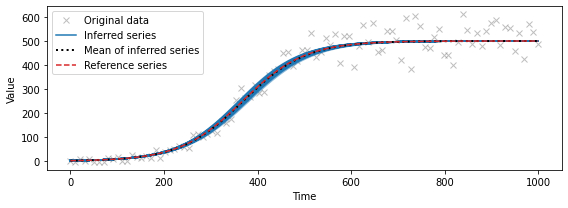

In [6]:
# Show predicted time series for the first chain
pints.plot.series(hacmc_chains[0, 200:], problem, true_parameters)
plt.show()

### 2. Infer parameters with Hamiltonian MCMC

In [7]:
#
# Infer model parameters with Hamiltonian MCMC.
#
# This cell needs the above defined true model parameters and the log-posterior:
# [true_parameters, log_posterior]
#

# Choose starting points for mcmc chains
xs = [
    true_parameters * 1.01,
    true_parameters * 0.98,
    true_parameters * 1.03,
]

# Create MCMC routine
mcmc = pints.MCMCController(
    log_pdf=log_posterior, 
    chains=len(xs),  # number of chains
    x0=xs,   # starting points
    method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Set step size
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size([0.0001, 0.5, 0.05, 0.05])

# Run!
print('Running...')
hmcmc_chains = mcmc.run()
print('Done!')

Running...
Using Hamiltonian Monte Carlo
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     63     0.333     0         0          0:00.0
2     123    0.25      0.25      0.25       0:00.1
3     183    0.4       0.4       0.4        0:00.1
100   6003   0.882     0.931     0.912      0:02.2
200   12003  0.931     0.960396  0.663      0:04.1
300   18003  0.944     0.97      0.728      0:06.0
400   24003  0.955     0.968     0.778607   0:07.9
500   30003  0.926     0.972     0.821      0:09.9
600   36003  0.935     0.965     0.847      0:11.9
700   42003  0.933     0.965812  0.838      0:13.8
800   48003  0.935     0.951     0.854      0:15.7
900   54003  0.939     0.951     0.859      0:17.6
1000  60003  0.942     0.954     0.864      0:19.5
1100  66003  0.943     0.958     0.872      0:21.5
1200  72003  0.942     0.959     0.876      0:23.5
1300  78003  0.942     0.961     0.884     

param       mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
----------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
r           0.01    0.00    0.01    0.01   0.01   0.02   0.02     1.00    1351.58  35.24
sigma_base  6.42    1.83    3.40    5.14   6.22   7.57   10.56    1.02    170.44   4.44
eta         0.81    0.15    0.63    0.69   0.77   0.89   1.17     1.03    123.00   3.21
sigma_rel   0.43    0.28    0.04    0.19   0.40   0.66   0.95     1.02    115.23   3.00


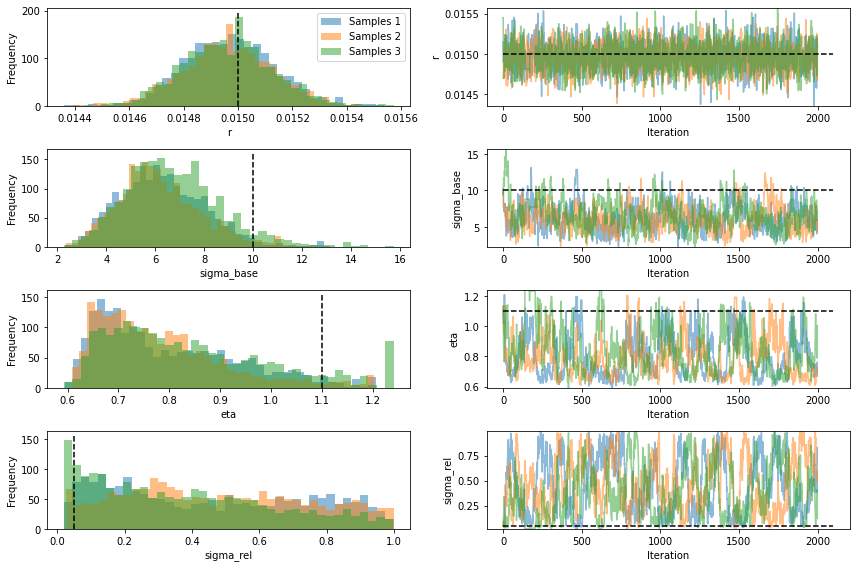

In [8]:
#
# Compute diagnostics and show diagnostic plots.
#
# This cell needs the HamiltonianMCMC chains:
# [hmcmc_chains]
#

import pints
import pints.plot


# Show diagnostics summary
results = pints.MCMCSummary(chains=hmcmc_chains, time=mcmc.time(), parameter_names=['r', 'sigma_base', 'eta', 'sigma_rel'])
print(results)

# Show trace and histogram
pints.plot.trace(samples=hmcmc_chains, parameter_names=['r', 'sigma_base', 'eta', 'sigma_rel'], ref_parameters=true_parameters)
plt.show()

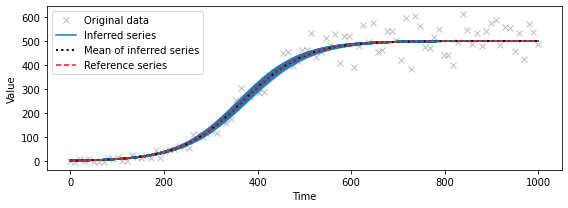

In [9]:
# Show predicted time series for the first chain
pints.plot.series(hmcmc_chains[0, 200:], problem, true_parameters)
plt.show()

## Explore partials of posterior

In [10]:
#
# Compute posterior scores and its derivatives over a range of values
#
# This cell needs the above defined true model parameters and the log-posterior:
# [true_parameters, log_posterior]
#

# Define container for paramters to be explored
n_parameters = len(true_parameters)  # (r, sigma_base, eta, sigma_rel)
n_evaluations = 50
parameter_ranges = np.empty(shape=(n_parameters, n_evaluations))

# Fill container with parameters
for param_id, param in enumerate(true_parameters):
    parameter_ranges[param_id, :] = np.linspace(start=0.2*param, stop=1.8*param, num=n_evaluations)

# Define container for posterior scores and its partials (along the direction of motion)
scores = np.empty(shape=(n_parameters, 2, n_evaluations))

# Loop through parameters (r, sigma_base, eta, sigma_rel)
for param_id, parameter_range in enumerate(parameter_ranges):
    # Get true parameters
    p = true_parameters.copy()

    # Loop through parameter values
    for eval_id, value in enumerate(parameter_range):
        # Compose point in parameter space
        p[param_id] = value

        # Evaluate posterior and its derivatives
        L, dL = log_posterior.evaluateS1(p)

        # Save posterior and relevant derivative in container
        scores[param_id, 0, eval_id] = L
        scores[param_id, 1, eval_id] = dL[param_id]  # Derivative in direction of motion


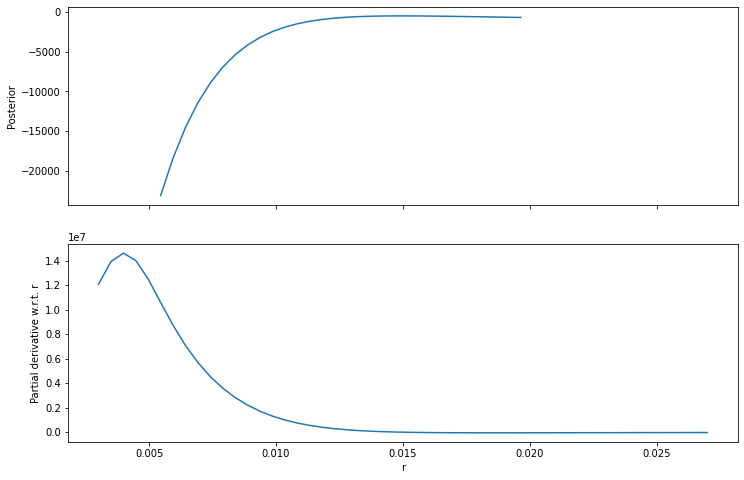

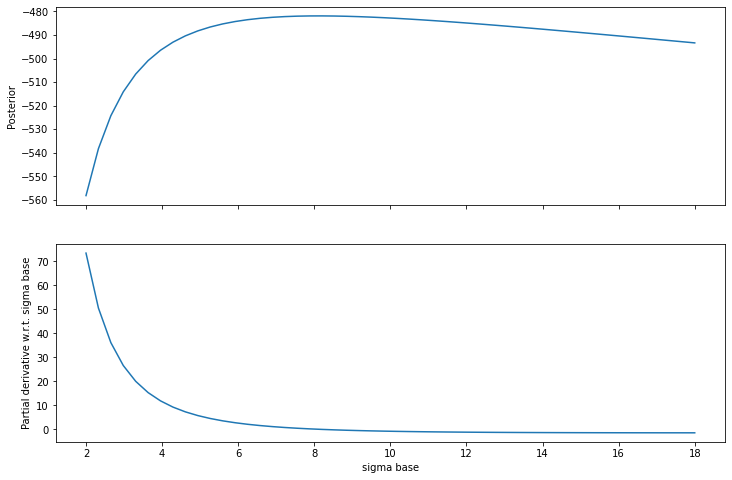

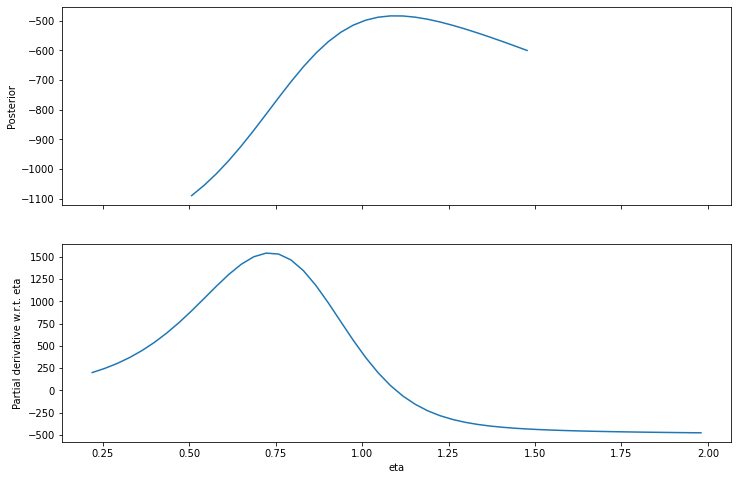

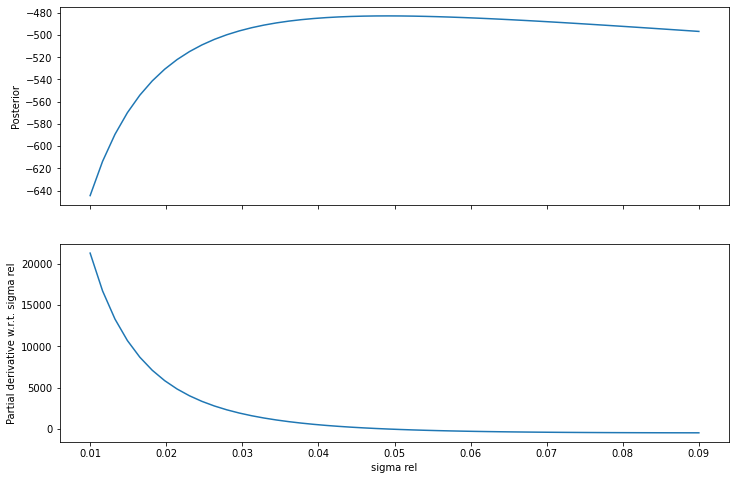

In [11]:
# 
# Visualise posterior and its derivatives.
#
# This cell needs the above computed scores and the relevant parameter ranges:
# [scores, parameter_ranges]
#

import matplotlib.pyplot as plt


# Define parameter names
names = ['r', 'sigma base', 'eta', 'sigma rel']

for param_id, params in enumerate(parameter_ranges):
    # Create figure 
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))

    # Plot posterior scores along r direction
    ax[0].plot(params, scores[param_id, 0, :])

    # Plot derivative ofposterior along r direction
    ax[1].plot(params, scores[param_id, 1, :])

    # Set y labels
    ax[0].set_ylabel('Posterior')
    ax[1].set_ylabel('Partial derivative w.r.t. %s' % names[param_id])

    # Set xlabel
    ax[1].set_xlabel(names[param_id])

    # Show figure
    plt.show()

## Is algorithm broken or is data not rich enough?

In [12]:
#
# Generate data for a logistic growth with a combined Gaussian error.
#

import numpy as np
import pints.toy


# Define model parameters
parameters = [2, 0.015, 500, 10, 1.1, 0.05]
f_0, r, k, sigma_base, eta, sigma_rel = parameters

# Instantiate logistic growth model with f(t=0) = f_0
model = pints.toy.LogisticModel(initial_population_size=f_0)

# Define measurement time points
times = np.linspace(start=0, stop=1000, num=1000)

# Solve logistic growth model
model_output = model.simulate(parameters=[r, k], times=times)

# Add noise to the model output according to the combined Gaussian error model
# Draw a standard Gaussian random variable for each model output
gauss = np.random.normal(loc=0.0, scale=1.0, size=len(model_output))

# Scale standard Gaussian noise according to error model
error = (sigma_base + sigma_rel * model_output**eta) * gauss

# Add noise to model output
observations = model_output + error

# Save data as time-observation tuples
data = np.vstack([times, observations])

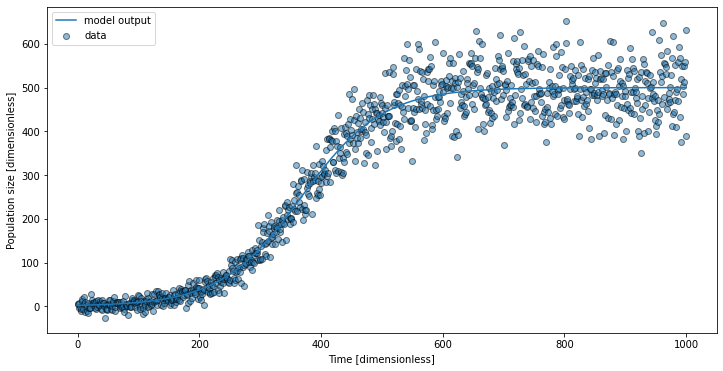

In [13]:
#
# Illustrate data.
#
# This cell needs the above defined data and model output:
# [data, model_output]
#

import matplotlib.pyplot as plt


# Create figure
plt.figure(figsize=(12, 6))

# Plot model output (no noise)
plt.plot(data[0, :], model_output, label='model output')

# Plot generated data
plt.scatter(data[0, :], data[1, :], label='data', edgecolors='black', alpha=0.5)

# Create X and Y axis title
plt.xlabel('Time [dimensionless]')
plt.ylabel('Population size [dimensionless]')

# Create legend
plt.legend()

# Show figure
plt.show()

In [14]:
#
# Construct posterior.
#
# Step 1: Wrap logistic growth model in a pints.ForwardModel()
# Step 2: Create a pints.SingleOutputProblem(), combining the data and the wrapped logostic growth model.
# Step 3: Create a pints.CombinedGaussianLogLikelihood() from the pints.SingleOutputProblem()
# Step 4: Define pints.LogPrior() for the model parameters.
# Step 5: Combine priors and likelihood to create a pints.LogPosterior().
#
# This cell needs the above defined true parameters, and the generated data:
# [parameters, data]
#

import numpy as np
import pints
import pints.toy


# Get true initial population size and carrying capacity
f_0 = parameters[0]
k = parameters[2]

# Forget about f_0 and k (we won't infer those parameters)
true_parameters = np.hstack([parameters[1:2], parameters[3:]])

# Create a wrapper around the logistic model
class Model(pints.ForwardModel):
    def __init__(self, f_0, k):
        self._k = k
        self._model = pints.toy.LogisticModel(initial_population_size=f_0)
    def simulate(self, parameters, times):
        return self._model.simulate(parameters=[parameters[0], self._k], times=times)
    def simulateS1(self, parameters, times):
        # Compute model output and gradients w.r.t. r and k
        values, gradient = self._model.simulateS1(parameters=[parameters[0], self._k], times=times)

        # Get gradient w.r.t. r
        gradient = gradient[:, 0]

        return values, gradient
    def n_parameters(self):
        return 1

# Create an inverse problem which links the logistic growth model to the data
problem = pints.SingleOutputProblem(model=Model(f_0=f_0, k=k), times=data[0, :], values=data[1, :])

# Create the combined Gaussian error log-likelihood
log_likelihood = pints.CombinedGaussianLogLikelihood(problem)

# Create uniform priors for [r, sigma_base, eta, sigma_rel]
log_prior_r = pints.UniformLogPrior(
    [0.005],
    [0.02]
)
log_prior_sigma_base = pints.UniformLogPrior(
    [1],
    [20]
)
log_prior_eta = pints.UniformLogPrior(
    [0.5],
    [1.5]
)
log_prior_sigma_rel = pints.UniformLogPrior(
    [0.001],
    [1]
)
log_prior = pints.ComposedLogPrior(
    log_prior_r, log_prior_sigma_base, log_prior_eta, log_prior_sigma_rel)

# Create posterior
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [15]:
#
# Infer model parameters with Haario ACMC.
#
# This cell needs the above defined true model parameters and the log-posterior:
# [true_parameters, log_posterior]
#

# Choose starting points for mcmc chains
xs = [
    true_parameters * 1.01,
    true_parameters * 0.9,
    true_parameters * 1.15,
]

# Create MCMC routine
mcmc = pints.MCMCController(
    log_pdf=log_posterior, 
    chains=len(xs),  # number of chains
    x0=xs,   # starting points
    method=pints.HaarioACMC)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Run!
print('Running...')
hacmc_chains = mcmc.run()
print('Done!')

Running...
Using Haario adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0.333      0:00.0
3     12     0         0         0.25       0:00.0
100   303    0         0.0297    0.0495     0:00.1
Initial phase completed.
200   603    0         0.0149    0.0249     0:00.1
300   903    0.15      0.14      0.166113   0:00.2
400   1203   0.209     0.209     0.197      0:00.3
500   1503   0.216     0.234     0.194      0:00.4
600   1803   0.211     0.23      0.198      0:00.5
700   2103   0.21      0.227     0.2        0:00.6
800   2403   0.212     0.221     0.186      0:00.7
900   2703   0.216     0.211     0.175      0:00.8
1000  3003   0.212     0.209     0.176      0:00.9
1100  3303   0.216     0.206     0.181653   0:01.1
1200  3603   0.213     0.204     0.184846   0:01.2
1300  3903

param       mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
----------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
r           0.02    0.00    0.01    0.01   0.02   0.02   0.02     1.00    1661.64  206.60
sigma_base  9.48    0.66    8.33    9.04   9.44   9.87   11.10    1.02    322.30   40.07
eta         0.94    0.07    0.83    0.89   0.93   0.98   1.10     1.03    80.63    10.03
sigma_rel   0.15    0.06    0.05    0.10   0.14   0.18   0.26     1.02    95.50    11.87


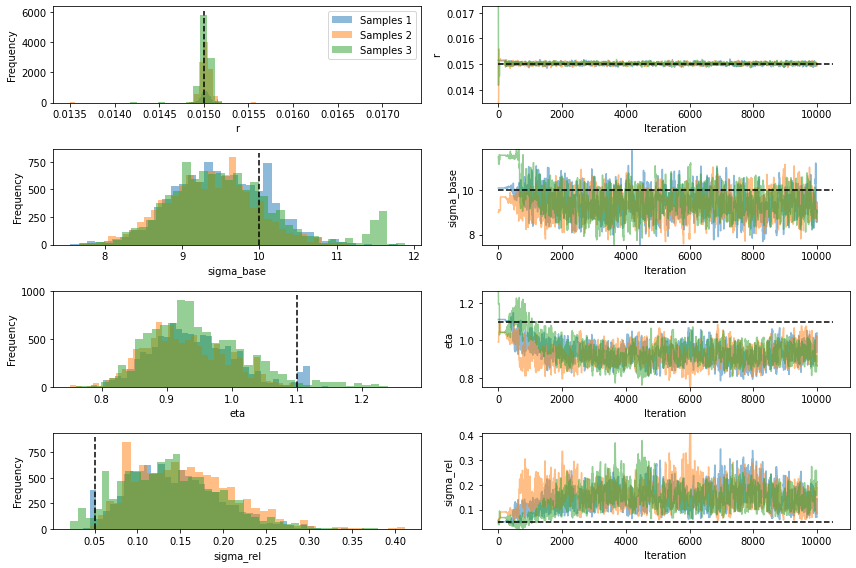

In [16]:
#
# Compute diagnostics and show diagnostic plots.
#
# This cell needs the HaarioACMC chains:
# [hacmc_chains]
#

import pints
import pints.plot


# Show diagnostics summary
results = pints.MCMCSummary(chains=hacmc_chains, time=mcmc.time(), parameter_names=['r', 'sigma_base', 'eta', 'sigma_rel'])
print(results)

# Show trace and histogram
pints.plot.trace(samples=hacmc_chains, parameter_names=['r', 'sigma_base', 'eta', 'sigma_rel'], ref_parameters=true_parameters)
plt.show()

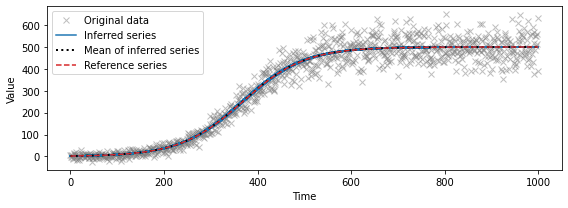

In [17]:
# Show predicted time series for the first chain
pints.plot.series(hacmc_chains[0, 200:], problem, true_parameters)
plt.show()

In [28]:
#
# Infer model parameters with Hamiltonian MCMC.
#
# This cell needs the above defined true model parameters and the log-posterior:
# [true_parameters, log_posterior]
#

# Choose starting points for mcmc chains
xs = [
    true_parameters * 1.01,
    true_parameters * 0.98,
    true_parameters * 1.03,
]

# Create MCMC routine
mcmc = pints.MCMCController(
    log_pdf=log_posterior, 
    chains=len(xs),  # number of chains
    x0=xs,   # starting points
    method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# # Set step size
# for sampler in mcmc.samplers():
#     old_step_sizes = np.array([0.0001, 0.5, 0.05, 0.05])
#     sampler.set_leapfrog_step_size(0.1 * old_step_sizes)

# Set step size
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size([0.00005, 5, 0.01, 0.008])
# Run!
print('Running...')
hmcmc_chains = mcmc.run()
print('Done!')

Running...
Using Hamiltonian Monte Carlo
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     63     0.333     0         0.333      0:00.1
2     123    0.5       0         0.5        0:00.1
3     183    0.6       0.2       0.6        0:00.2
100   6003   0.853     0.824     0.863      0:03.9
200   12003  0.886     0.871     0.871      0:07.3
300   18003  0.891     0.874     0.884106   0:10.8
400   24003  0.876     0.878     0.888      0:14.3
500   30003  0.878     0.886     0.886      0:17.9
600   36003  0.885     0.887     0.889      0:21.2
700   42003  0.887     0.877     0.89       0:24.8
800   48003  0.884     0.877     0.895      0:28.3
900   54003  0.881     0.878     0.891      0:32.0
1000  60003  0.884     0.883     0.892      0:35.6
1100  66003  0.886     0.887     0.888      0:39.2
1200  72003  0.886     0.887     0.889      0:42.9
1300  78003  0.886     0.884     0.889     

param       mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
----------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
r           0.02    0.00    0.01    0.01   0.02   0.02   0.02     1.00    2000.00  28.25
sigma_base  9.37    0.69    8.06    8.90   9.36   9.82   10.73    1.02    109.32   1.54
eta         0.92    0.07    0.80    0.87   0.92   0.97   1.08     1.05    50.04    0.71
sigma_rel   0.16    0.07    0.05    0.11   0.15   0.21   0.33     1.05    45.00    0.64


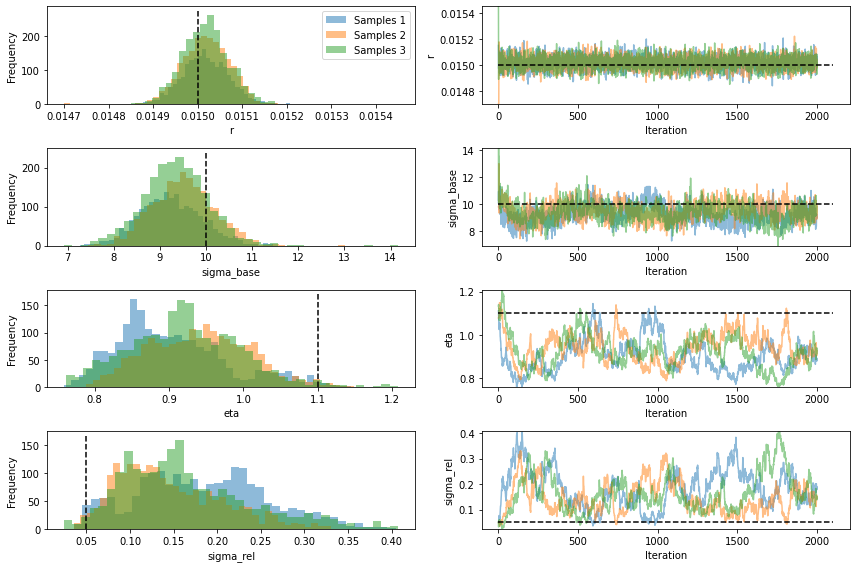

In [29]:
#
# Compute diagnostics and show diagnostic plots.
#
# This cell needs the HamiltonianMCMC chains:
# [hmcmc_chains]
#

import pints
import pints.plot


# Show diagnostics summary
results = pints.MCMCSummary(chains=hmcmc_chains, time=mcmc.time(), parameter_names=['r', 'sigma_base', 'eta', 'sigma_rel'])
print(results)

# Show trace and histogram
pints.plot.trace(samples=hmcmc_chains, parameter_names=['r', 'sigma_base', 'eta', 'sigma_rel'], ref_parameters=true_parameters)
plt.show()

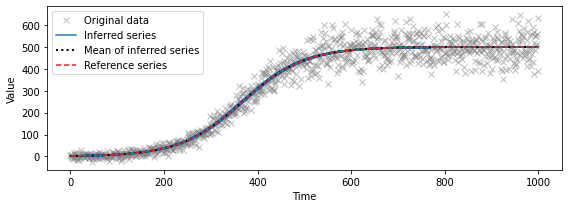

In [20]:
# Show predicted time series for the first chain
pints.plot.series(hmcmc_chains[0, 200:], problem, true_parameters)
plt.show()

In [21]:
#
# Compute posterior scores and its derivatives over a range of values
#
# This cell needs the above defined true model parameters and the log-posterior:
# [true_parameters, log_posterior]
#

# Define container for paramters to be explored
n_parameters = len(true_parameters)  # (r, sigma_base, eta, sigma_rel)
n_evaluations = 50
parameter_ranges = np.empty(shape=(n_parameters, n_evaluations))

# Fill container with parameters
for param_id, param in enumerate(true_parameters):
    parameter_ranges[param_id, :] = np.linspace(start=0.2*param, stop=1.8*param, num=n_evaluations)

# Define container for posterior scores and its partials (along the direction of motion)
scores = np.empty(shape=(n_parameters, 2, n_evaluations))

# Loop through parameters (r, sigma_base, eta, sigma_rel)
for param_id, parameter_range in enumerate(parameter_ranges):
    # Get true parameters
    p = true_parameters.copy()

    # Loop through parameter values
    for eval_id, value in enumerate(parameter_range):
        # Compose point in parameter space
        p[param_id] = value

        # Evaluate posterior and its derivatives
        L, dL = log_posterior.evaluateS1(p)

        # Save posterior and relevant derivative in container
        scores[param_id, 0, eval_id] = L
        scores[param_id, 1, eval_id] = dL[param_id]  # Derivative in direction of motion


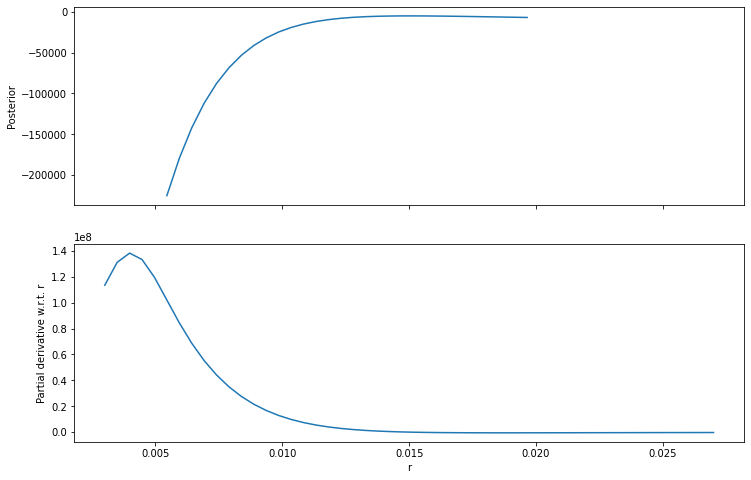

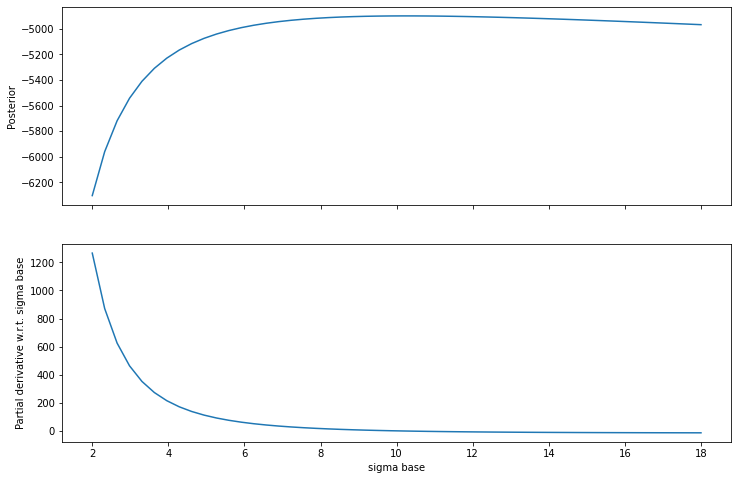

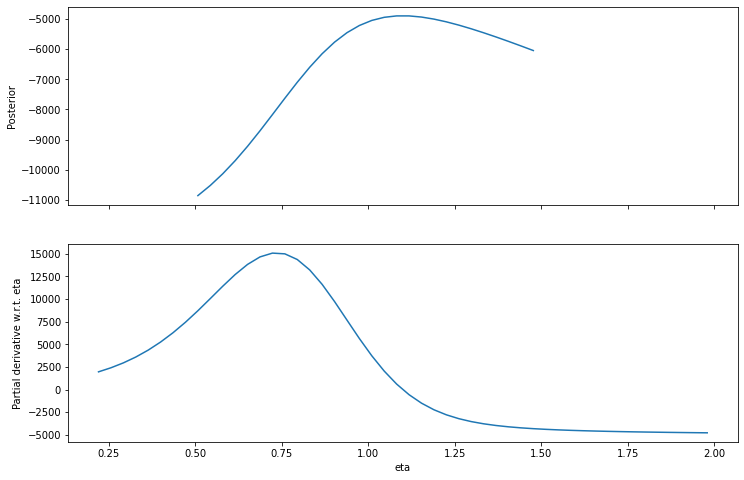

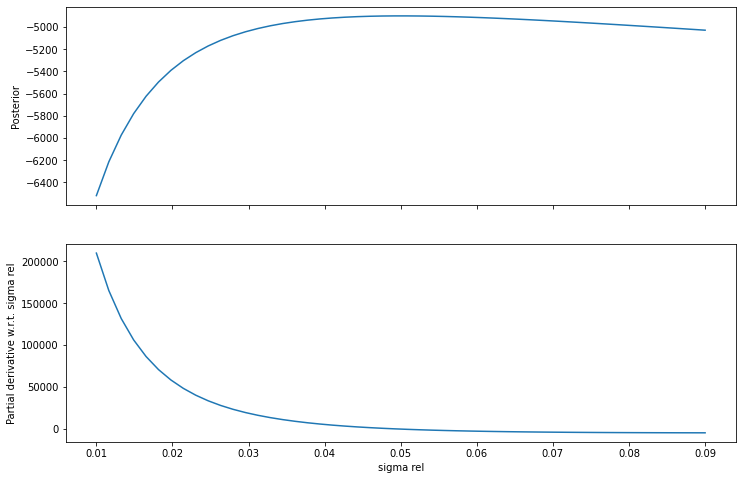

In [22]:
# 
# Visualise posterior and its derivatives.
#
# This cell needs the above computed scores and the relevant parameter ranges:
# [scores, parameter_ranges]
#

import matplotlib.pyplot as plt


# Define parameter names
names = ['r', 'sigma base', 'eta', 'sigma rel']

for param_id, params in enumerate(parameter_ranges):
    # Create figure 
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))

    # Plot posterior scores along r direction
    ax[0].plot(params, scores[param_id, 0, :])

    # Plot derivative ofposterior along r direction
    ax[1].plot(params, scores[param_id, 1, :])

    # Set y labels
    ax[0].set_ylabel('Posterior')
    ax[1].set_ylabel('Partial derivative w.r.t. %s' % names[param_id])

    # Set xlabel
    ax[1].set_xlabel(names[param_id])

    # Show figure
    plt.show()